
# Autoencoder

In this notebook, you will implement an autoencoder. An autoencoder seeks to learn a latent representation of our training images by using unlabeled data and learning to reconstruct its inputs.

In [1]:
# DO NOT MODIFY THIS CELL!
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, plot_latent_space, plot_latent_space_images


In [2]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Use this only if you are running on M1/M2 macbooks
# dtype = torch.float
# device = torch.device("mps")
# print(device)

## Load MNIST Dataset


We will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9).

We will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `data`. 

In [4]:
#TODO
hidden_dim = 256 # encoder and decoder hidden layer size
latent_dim = 2 # Z 
batch_size = 64
n_epochs = 15

transform = transforms.Compose(
        [transforms.ToTensor()]
    ) # TODO, convert data to torch.FloatTensor, transforming  data to 0 and 1
mnist_train = datasets.MNIST('./data', 
               transform=transform, 
               download=True, train=True)

loader_train = DataLoader(mnist_train, batch_size=batch_size,
                           shuffle=True, drop_last=True, num_workers=2) 

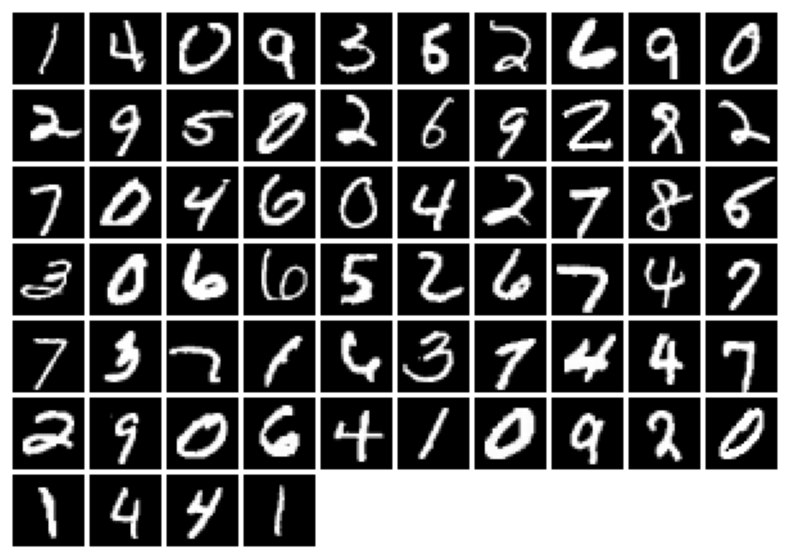

In [5]:
imgs = next(iter(loader_train))[0].numpy().squeeze() 
visualize_img_batch(imgs)

In [6]:
# Reshaping the matrix
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        # The -1 in reshape method is a placeholder that PyTorch fills in with the appropriate value based on the batch size
        return x.view(-1, *self.shape) 

class Autoencoder(nn.Module):
    def __init__(self, latent_dim,hidden_dim,input_dim):
        super(Autoencoder, self).__init__()
        output_dim = input_dim
        #TODO
        self.encoder = nn.Sequential(
            Reshape(28*28),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
            Reshape(1,28,28)
        )

    def forward(self, x):
        #TODO
        # pass
        x = x.reshape(-1, 28*28)
        z = self.encoder(x) # latent representation 
        # z = z.view(-1, 28,28)
        out = self.decoder(z) # reconstructed image
        
        return out, z 

In [7]:
from torchsummary import summary
autoencoder = Autoencoder(latent_dim, hidden_dim,784).to(device)
summary(autoencoder,(1,28,28), device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
         LeakyReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
         LeakyReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
         LeakyReLU-7                  [-1, 256]               0
            Linear-8                    [-1, 2]             514
            Linear-9                  [-1, 256]             768
        LeakyReLU-10                  [-1, 256]               0
           Linear-11                  [-1, 256]          65,792
        LeakyReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 256]          65,792
        LeakyReLU-14                  [

In [8]:
from tqdm import tqdm
criterion = nn.MSELoss() # TODO: specify loss function
lr = 1e-3
optimizer = torch.optim.Adam(autoencoder.parameters(),lr =  lr) # TODO: specify optimizer

logs = { "train_mse_loss": []}

for epoch in range(n_epochs):
    train_loss = 0
    with tqdm(loader_train, unit="batch") as tepoch:
        for x, y in tepoch:
            #TODO
            # clear the gradients of all optimized variables
            # forward pass:
            # calculate the loss using the criterion defined above
            # backward pass: compute gradient of the loss with respect to model parameters
            # perform a single optimization step (parameter update)
            # update running training loss
            tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
            optimizer.zero_grad()
            x = x.to(device)
            out, z  = autoencoder(x)
            loss = criterion(out.reshape(-1,28*28), x.reshape(-1, 28*28))
            loss.backward()
            optimizer.step()
            # compute running loss
            train_loss += loss.item()/len(loader_train)
            # train_loss = train_loss/len(loader_train)
            
            tepoch.set_postfix(train_loss=train_loss)
            # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    logs["train_mse_loss"].append(train_loss)

Epoch[15/15] train: 100%|██████████| 937/937 [00:08<00:00, 106.50batch/s, train_loss=0.0344] 


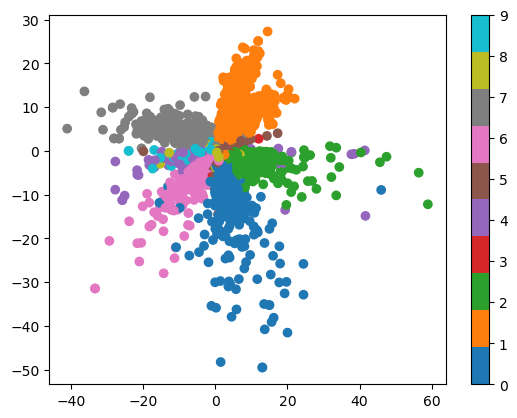

In [9]:
# show latent space distribution

plot_latent_space(autoencoder.encoder, loader_train, device)

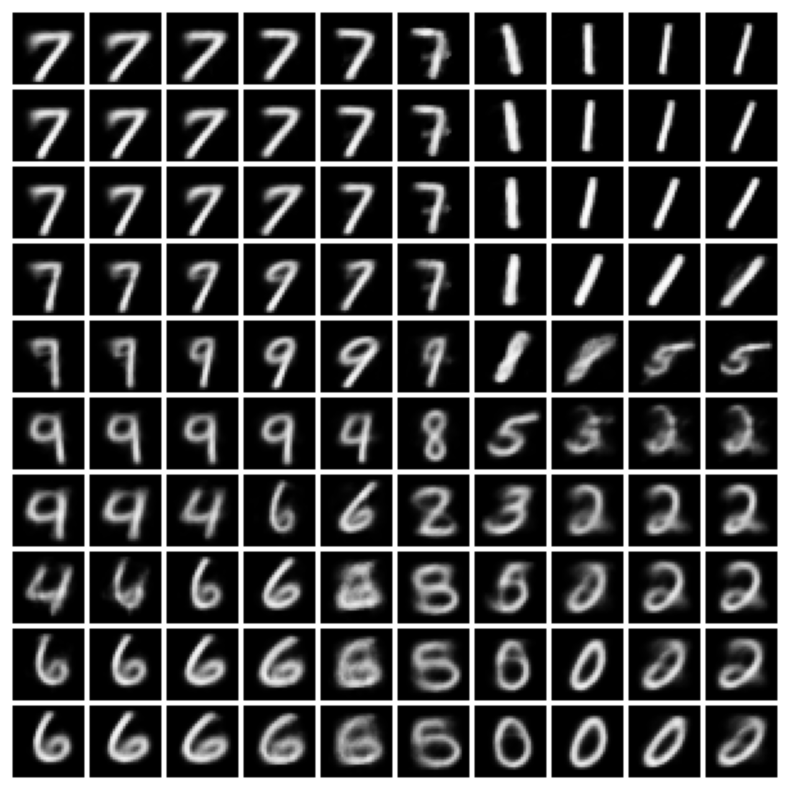

In [10]:
# show reconstruction from latent space images

plot_latent_space_images(autoencoder.decoder, device)

In [11]:
import json 
with open("./logs/ae_logs.json", "w") as f:
    json.dump(logs, f)

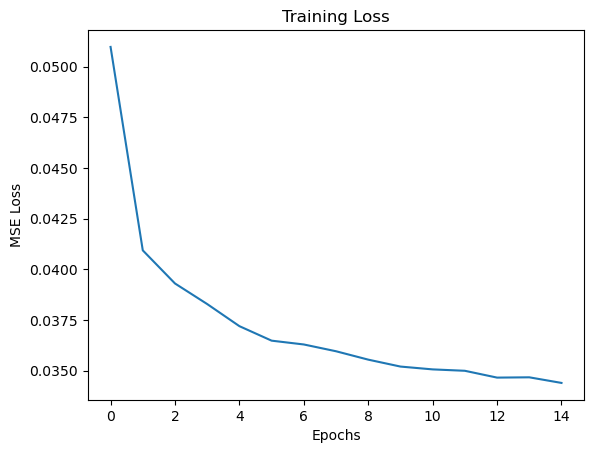

In [14]:
import matplotlib.pyplot as plt
plt.plot(logs["train_mse_loss"])
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.savefig("./figs/ae_loss.png")